In [2]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import image_to_train as tr
from model import get_model
import test_func as test
import time

2024-02-27 09:16:32.745064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# load desired model
model = get_model()
x2_weight_path = os.path.join('saved_weights', 'Weightx2', 'x2.ckpt')
model = test.load_x2_from_weights(model, x2_weight_path)

2024-02-27 09:16:34.303073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 09:16:34.303109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# working with bigger datasets can cause memory issues; limit the number of images you generate by indexing the images
# else, set the value of try_all_images = True
start_idx = 0
end_idx = 20
try_all_images = False
dataset_path = os.path.join('I20', 'raw')           # path to image dataset

if try_all_images:
    image_paths = [os.path.join(dataset_path, f) for f in sorted(os.listdir(dataset_path))]
else:
    image_paths = [os.path.join(dataset_path, f) for f in sorted(os.listdir(dataset_path))[start_idx:end_idx]]

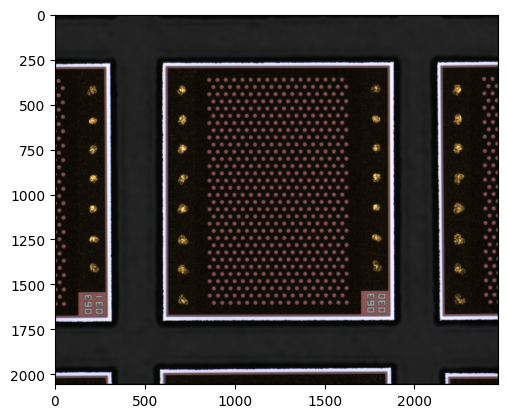

In [9]:
def read_and_decode(path):
    im = tf.io.read_file(path)
    im = tf.image.decode_image(im, channels=3)
    return im
rgb_images = [read_and_decode(path) for path in image_paths]
images = np.array([tr.preprocess_single_image(im, channel_last=True) for im in rgb_images])
plt.imshow(rgb_images[0])
plt.axis('off')

In [11]:
# get SR sub-band residuals
predictions = []
for image in images:
    prediction = model.predict(image, verbose=0)
    predictions.append(tf.squeeze(prediction))

In [12]:
# add residuals to LR image and convert sub-bands to luminance image
squeezed_images = images.squeeze()
SR_bands = [im + pred for im, pred in zip(squeezed_images, predictions)]
SR_lum = []
for bands in SR_bands:
    SR_lum.append(tr.bands_to_image(bands))

In [13]:
# convert luminance to rgb
SR_rgb_images = [test.luminance_to_rgb(lum, rgb) for lum, rgb in zip(SR_lum, rgb_images)]

(-0.5, 4927.5, 4111.5, -0.5)

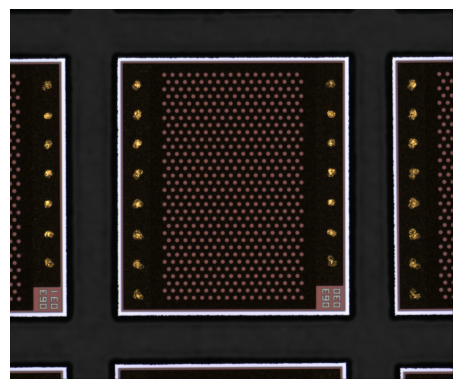

In [14]:
# confirm images
plt.imshow(SR_rgb_images[0])
plt.axis('off')

In [ ]:
# store results in out_path directory
out_path = os.path.join('I20', 'SR_x2')
file_names = ['{:03d}'.format(i) for i in range(start_idx+1, end_idx+1)]
test.write_images_to_path(out_path, SR_rgb_images, file_names)